In [1]:
import glob
import os
import gc
import json
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import math

from datetime import datetime

from chime_frb_api.backends import frb_master

try:
    from frb_common import common_utils
    freq_bottom_mhz = common_utils.freq_bottom_mhz
    freq_top_mhz = common_utils.freq_top_mhz
    freq = common_utils.freq
except ImportError:
    freq_bottom_mhz = 400.1953125
    freq_top_mhz = 800.1953125
    freq = np.arange(freq_bottom_mhz + 0.0244140625 / 2.0, freq_top_mhz,
        0.0244140625)

Using hard-coded default config. Run update_from_site_config() toget config from kotekan


In [2]:
def scrunch_npy(npy_fil, f_scrunch=1, t_scrunch=1):
    '''
    Scrunch data in frequency and time.
    '''
    
    ### Add cases when t_scrunch doesn't divide exactly ####
    data = npy_fil
    if (data.shape[1] % t_scrunch) == 0:
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    else:
        t_range = data.shape[1] - (data.shape[1] % t_scrunch) ### Make the number divisible by subtrating remainder
        print("Time range adjusted for scrunching", t_range)
        data = data[:,:t_range]
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    return data

def calc_xticks(wfall, t_res):
    
    ts = np.sum(wfall, axis=0)
    max_ts = np.argmax(ts)
    
    xticks = []
    num = 6
    step = int(len(ts)/num)
    
    for j in range(0,num):
        x_left = max_ts - step*j
        x_right = max_ts + step*(j+1)
        
        if x_left > 0:
            xticks.append(x_left)
        if x_right < len(ts):
            xticks.append(x_right)
    
    
    xticks = np.sort(np.unique(np.array(xticks)))
        
    xticks_lab = np.around(((xticks - max_ts) * t_res) / 1000, decimals=0).astype(int)
    
    
    return xticks, xticks_lab
    
    

def plot_event(wfall, model_wfall, freq_res, time_res, dm, i, low_freq, high_freq, save_fname):
    
    outer_grid = gridspec.GridSpec(1, 1, wspace=0, hspace=0.25)
    for j, outer in enumerate(outer_grid):
        outer = outer
    plt.figure(figsize=(6,6))
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer,
                                          width_ratios=[3, 1],
                                          height_ratios=[1, 3],
                                          hspace=0.0, wspace=0.0)

    data_im = plt.subplot(gs[2])
    data_ts = plt.subplot(gs[0], sharex=data_im)
    data_spec = plt.subplot(gs[3], sharey=data_im)
    
    vmin = np.nanpercentile(wfall, 1)
    vmax = np.nanpercentile(wfall, 99)
    


    wfall[np.isnan(wfall)] = np.nanmedian(wfall)
    print("Waterfall shape after scrunch", wfall.shape)
    
    model_ts = np.sum(model_wfall, axis=0)
    
    ts = np.sum(wfall, axis=0)
    spec = np.sum(wfall, axis=1)
    
    plot_time = np.arange(0,len(ts),1)
    plot_freq = np.linspace(400, 800, len(spec))

    
    #plot wfall
    data_im.imshow(wfall, aspect="auto", origin='lower',interpolation="none", 
                   vmin=vmin, vmax=vmax, cmap='viridis')

    #plot time series
    data_ts.plot(plot_time, ts, color="k", drawstyle="steps-post")

    # plot spectrum
    data_spec.plot(spec, np.arange(0, len(spec)), color="k", drawstyle="steps-post")
    
    data_ts.plot(np.arange(0,len(model_ts),1), model_ts,color="r")
    
    plt.setp(data_ts.get_xticklabels(), visible=False)
    data_ts.set_yticklabels([], visible=True)
    data_ts.set_yticks([])
    plt.setp(data_spec.get_yticklabels(), visible=False)
    data_spec.set_xticklabels([], visible=True)
    data_spec.set_xticks([])
    
    ## Tick Labels ###
    y_ticks = np.linspace(0,len(spec),5).astype(int)
    if y_ticks[-1] > (len(spec)-1):
        y_ticks[-1] = len(spec) - 1
    yticklabels = [400, 500, 600, 700, 800]#plot_freq[y_ticks].astype(int)
    x_ticks, xticklabels = calc_xticks(wfall, t_res)
    
    low_idx = (np.abs(plot_freq - low_freq)).argmin() ### Calculating the idx where frequency is closest ###
    high_idx = (np.abs(plot_freq - high_freq)).argmin() 
    
    data_im.axhline(low_idx, c='white', linestyle = '--')
    data_im.axhline(high_idx, c='white', linestyle = '--')

    
    data_im.set_yticks(y_ticks)
    data_im.set_yticklabels(yticklabels, fontsize=10)
    data_im.set_xticks(x_ticks)
    data_im.set_xticklabels(xticklabels, fontsize=10)
    data_im.set_ylabel("Frequency (MHz)", fontsize=10)
    data_im.set_xlabel("Time (ms)", fontsize=10)
    
    xlim = data_ts.get_xlim()
    ylim = data_ts.get_ylim()
    ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
    xpos = (xlim[1] - xlim[0]) * 0.98 + 0
    data_ts.text(xpos, ypos, "{}\n{:.1f} $\mu$s".format(round(dm,2), t_res), ha="right",
                 va="top", fontsize=10)
    data_ts.text(0.25,ypos,"B{}".format(i+1), ha="left", va="top", fontsize=12)
    
    
    plt.savefig(save_fname, dpi=300, bbox_inches = 'tight')
    plt.show()
    
def get_spec_param(model_wfall, band_low, band_high, nchan, plot=False):
        
        spec = np.sum(model_wfall, axis=1)
        spec_fwtm = np.max(spec)/10
        
        freq = np.linspace(band_low, band_high, nchan)
        
        peak = np.argmax(spec)
        
        low = np.min(np.where(spec>spec_fwtm))
        high = np.max(np.where(spec>spec_fwtm))
        
        if freq[low] < band_low:
            freq[low] = band_low
        if freq[high] > band_high:
            freq[high] = band_high

        center = (freq[low] + freq[high])/2
        bw = freq[high]-freq[low]
        
        if plot:
            plt.plot(freq,spec)
            plt.axvline(freq[low], color = 'r')
            plt.axvline(freq[high], color = 'b')
            plt.axvline(freq[peak], color = 'g')
            plt.axvline(center, color = 'k')
            plt.show()
            
        return freq[low], freq[high], freq[peak]
    

In [3]:
basepath = '/data/user-data/ksand/R3/fitburst_run_final/'
entries = os.listdir(basepath)
entries.remove('.ipynb_checkpoints')
entries = np.array(entries).astype(int)
entries = np.sort(entries)
print(entries)
print(entries.shape)
print(entries.tolist())

[ 23789294  23891929  40363753  40750224  40750656  60073678  65395717
  65511496  67522832  67522901  69509443  71665813  71784400  71784833
  71785167  73726599  83984528  84081108  92773515  92844954 135577833
 151677988 153859596 154910364 154913824 155079679 163181014 163362088
 163534005 166812476 171681248 171855709 175004577 175929272 176060009
 180666196 180667327 188553320 194488374 194488393 194488454 195132396
 200973875 203798724 203935225]
(45,)
[23789294, 23891929, 40363753, 40750224, 40750656, 60073678, 65395717, 65511496, 67522832, 67522901, 69509443, 71665813, 71784400, 71784833, 71785167, 73726599, 83984528, 84081108, 92773515, 92844954, 135577833, 151677988, 153859596, 154910364, 154913824, 155079679, 163181014, 163362088, 163534005, 166812476, 171681248, 171855709, 175004577, 175929272, 176060009, 180666196, 180667327, 188553320, 194488374, 194488393, 194488454, 195132396, 200973875, 203798724, 203935225]


In [4]:
basepath = '/data/user-data/ksand/R3/fitburst_run_final/'
event_ids = []
pm_files = []
result_files = []
input_files = []
summary = []
for event in entries:
    if (event != '.ipynb_checkpoints'): 
        path_to_event = os.path.join(basepath, str(event))
        trials = np.array(os.listdir(path_to_event))
        count = 0


        for trial in trials:
            if (trial != '.ipynb_checkpoints'):
                path_to_file = os.path.join(path_to_event, trial)
                event_ids.append(int(event))
                np.array(pm_files.append(glob.glob(path_to_file + '/pm*.npz')))
                np.array(result_files.append(glob.glob(path_to_file + '/result*.npz')))
                np.array(input_files.append(glob.glob(path_to_file + '/R3*.npz')))
                np.array(summary.append(glob.glob(path_to_file + '/summary*.png')))
                count = count + 1

In [5]:
npz_files = []
for pm_file, event, input_file, result_file in zip(pm_files,event_ids,input_files,result_files):
    npz_files.append(event)
    
    data_input = np.load(input_file[0], allow_pickle = True)
    input_npz = data_input['data_full']
    npz_files.append(input_npz)
    
    data_pm = np.load(pm_file[0], allow_pickle = True)
    ds = data_pm['arr_0'].item(0)['ds']
    #print(event, ds)
    dm = data_pm['arr_0'].item(0)['DM']
    data_res = np.load(result_file[0], allow_pickle=True)
    model = data_res['arr_0'][2]
    
    npz_files.append(ds)
    npz_files.append(dm)
    npz_files.append(model)

In [6]:
event_id = '23789294'
for i in range(0,len(npz_files),5):
    if str(npz_files[i]) == event_id:
        #print(npz_files[i],npz_files[i+2])
        wfall = npz_files[i+1]
        #print(wfall.shape)
        model_wfall = npz_files[i+4]
        #print(model_wfall.shape)
        ts = np.sum(wfall, axis=0)
        #print(ts.shape)
        model_ts = np.sum(model_wfall, axis=0)
        #print(model_ts.shape)
        spec = np.sum(wfall, axis=1)
        ds = npz_files[i+2]
        e = npz_files[i]
        dm = npz_files[i+3]
        #print(e, dm)

Waterfal shape (1024, 320)
Waterfall shape after scrunch (128, 320)


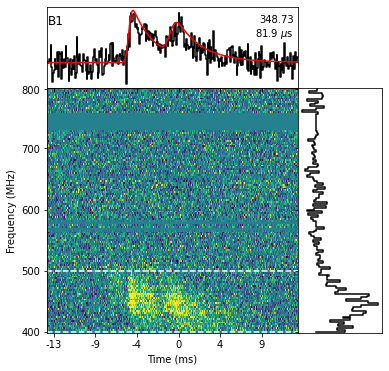

Waterfal shape (1024, 528)
Waterfall shape after scrunch (128, 528)


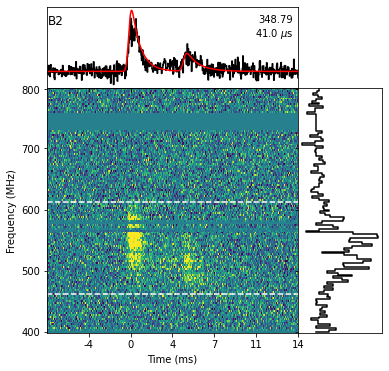

Waterfal shape (1024, 721)
Waterfall shape after scrunch (128, 721)


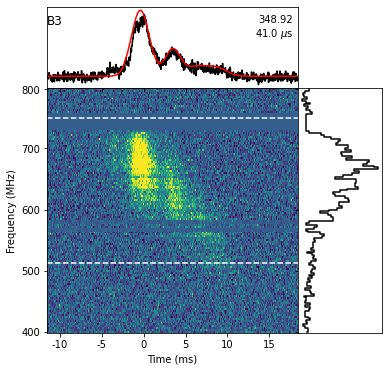

Waterfal shape (1024, 143)
Waterfall shape after scrunch (128, 143)


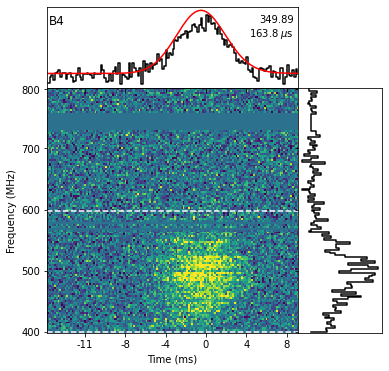

Waterfal shape (1024, 493)
Waterfall shape after scrunch (128, 493)


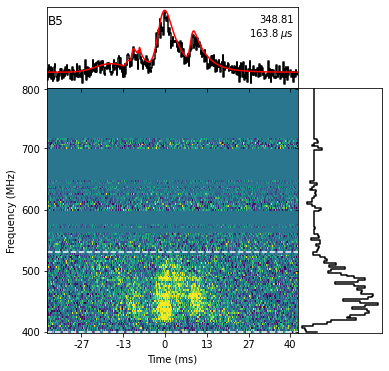

Waterfal shape (1024, 200)
Waterfall shape after scrunch (128, 200)


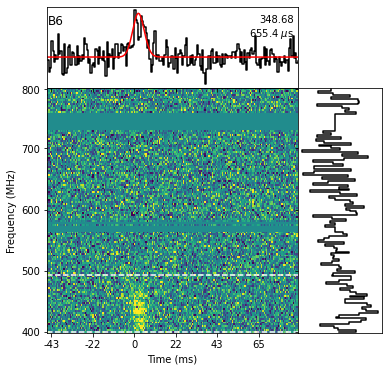

Waterfal shape (1024, 74)
Waterfall shape after scrunch (128, 74)


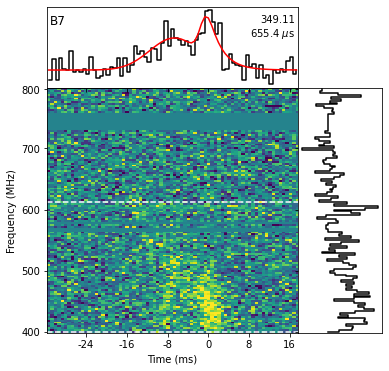

Waterfal shape (1024, 200)
Waterfall shape after scrunch (128, 200)


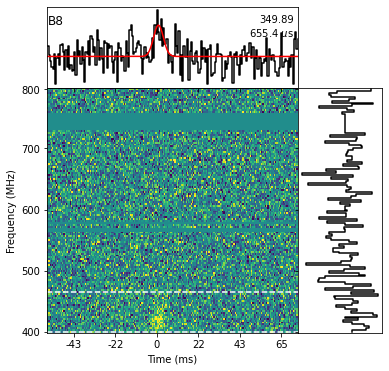

Waterfal shape (1024, 32)
Waterfall shape after scrunch (128, 32)


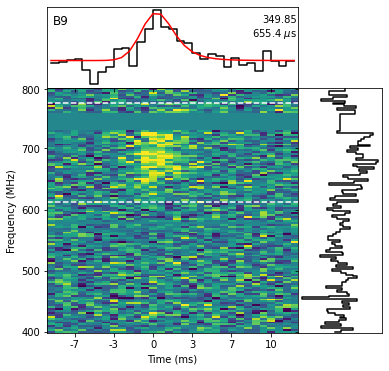

Waterfal shape (1024, 138)
Waterfall shape after scrunch (128, 138)


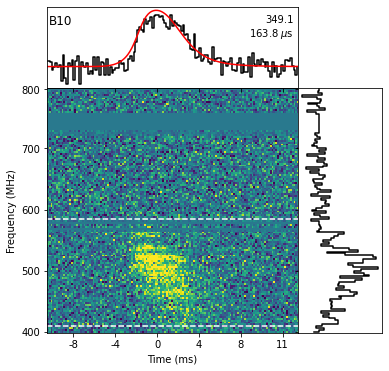

Waterfal shape (1024, 106)
Waterfall shape after scrunch (128, 106)


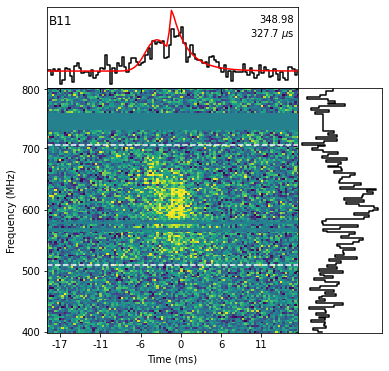

Waterfal shape (1024, 35)
Waterfall shape after scrunch (128, 35)


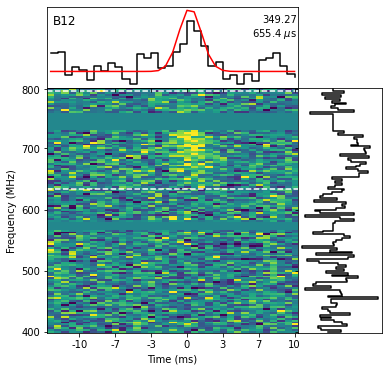

Waterfal shape (1024, 100)
Waterfall shape after scrunch (128, 100)


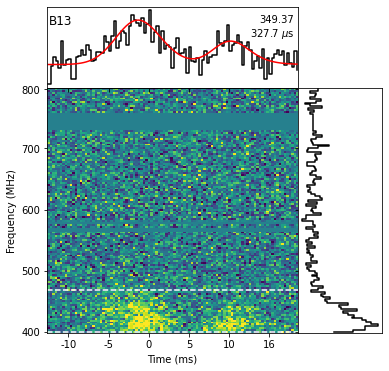

Waterfal shape (1024, 38)
Waterfall shape after scrunch (128, 38)


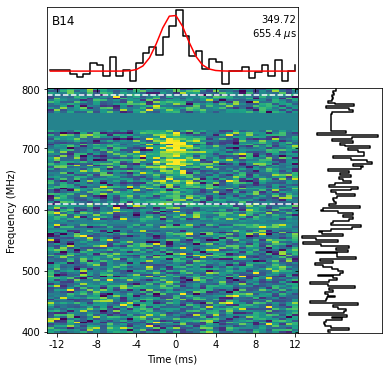

Waterfal shape (1024, 57)
Waterfall shape after scrunch (128, 57)


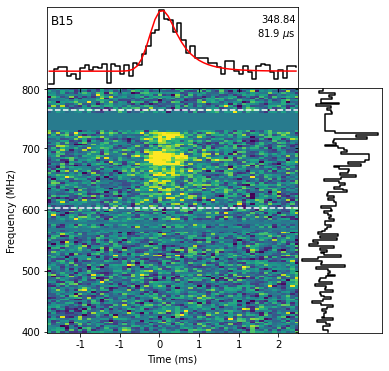

Waterfal shape (1024, 154)
Waterfall shape after scrunch (128, 154)


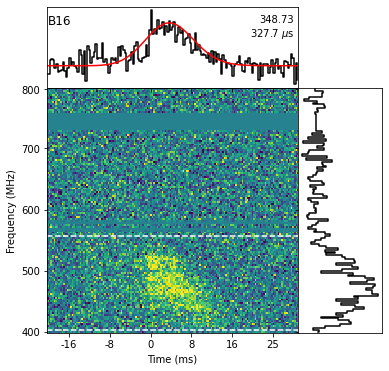

Waterfal shape (1024, 160)
Waterfall shape after scrunch (128, 160)


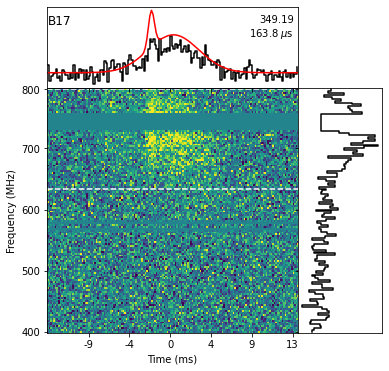

Waterfal shape (1024, 51)
Waterfall shape after scrunch (128, 51)


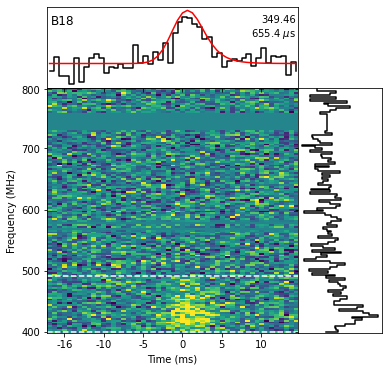

Waterfal shape (1024, 208)
Waterfall shape after scrunch (128, 208)


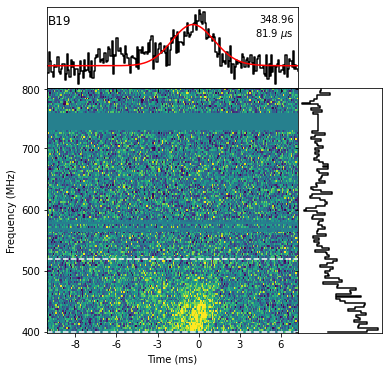

Waterfal shape (1024, 601)
Waterfall shape after scrunch (128, 601)


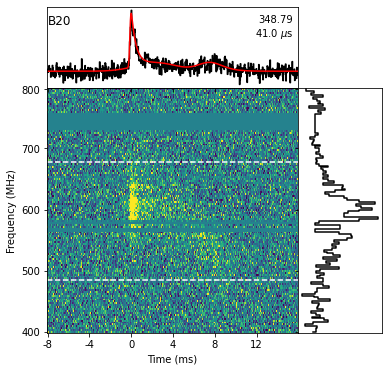

Waterfal shape (1024, 150)
Waterfall shape after scrunch (128, 150)


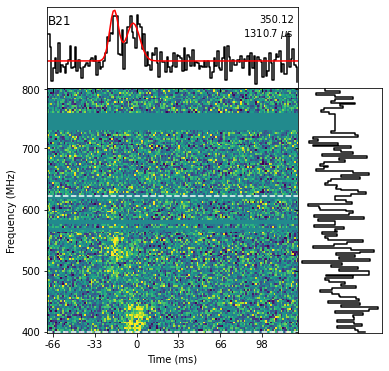

Waterfal shape (1024, 51)
Waterfall shape after scrunch (128, 51)


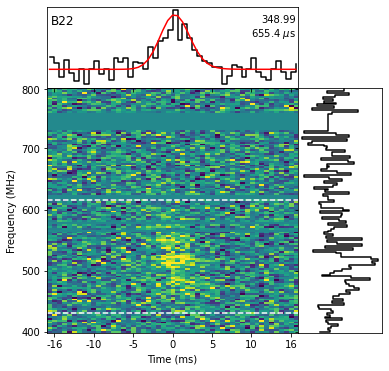

Waterfal shape (1024, 70)
Waterfall shape after scrunch (128, 70)


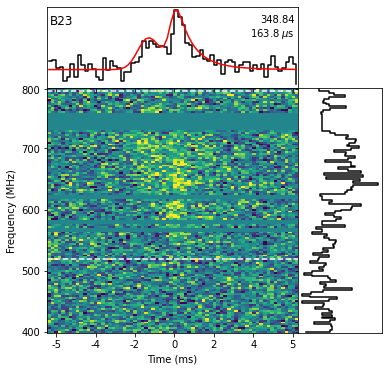

Waterfal shape (1024, 58)
Waterfall shape after scrunch (128, 58)


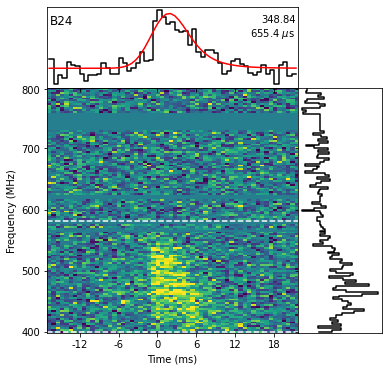

Waterfal shape (1024, 122)
Waterfall shape after scrunch (128, 122)


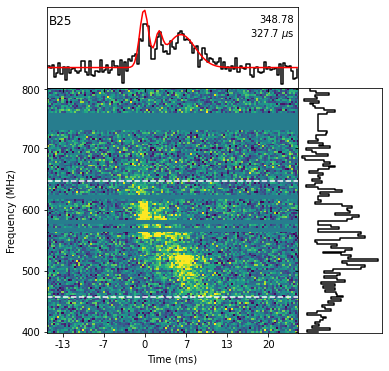

Waterfal shape (1024, 35)
Waterfall shape after scrunch (128, 35)


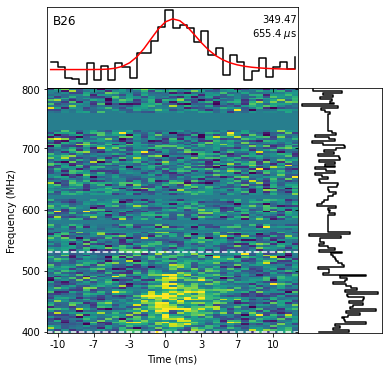

Waterfal shape (1024, 144)
Waterfall shape after scrunch (128, 144)


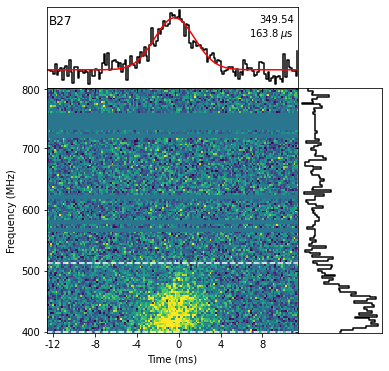

Waterfal shape (1024, 61)
Waterfall shape after scrunch (128, 61)


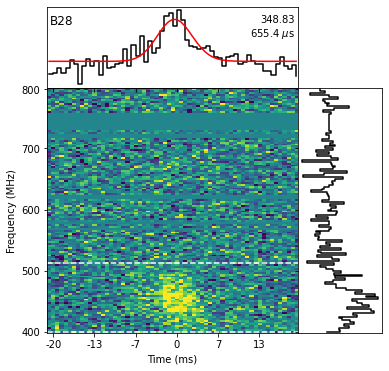

Waterfal shape (1024, 99)
Waterfall shape after scrunch (128, 99)


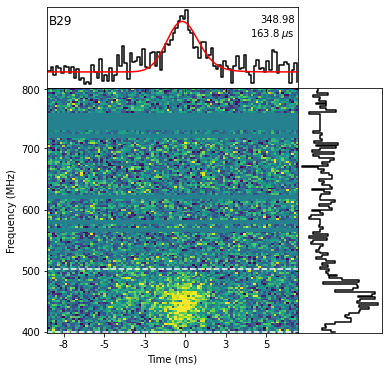

Waterfal shape (1024, 246)
Waterfall shape after scrunch (128, 246)


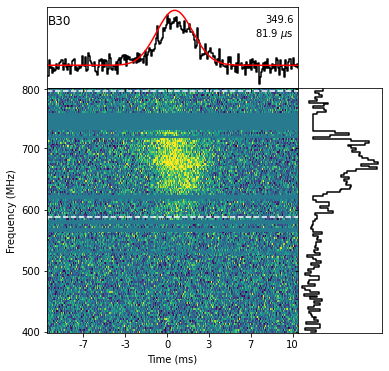

Waterfal shape (1024, 35)
Waterfall shape after scrunch (128, 35)


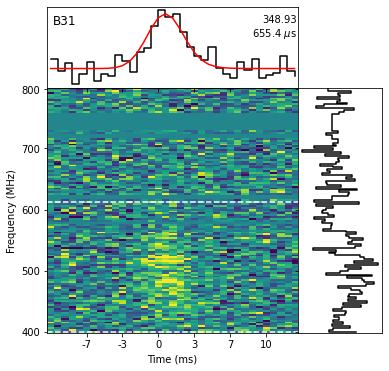

Waterfal shape (1024, 70)
Waterfall shape after scrunch (128, 70)


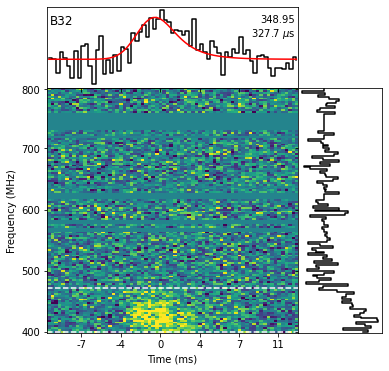

Waterfal shape (1024, 48)
Waterfall shape after scrunch (128, 48)


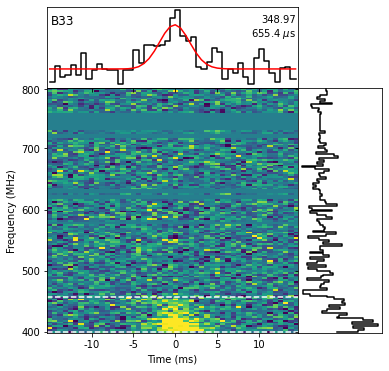

Waterfal shape (1024, 54)
Waterfall shape after scrunch (128, 54)


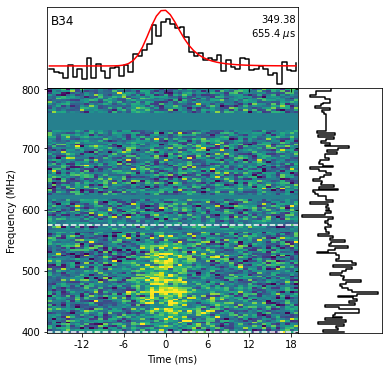

Waterfal shape (1024, 1206)
Waterfall shape after scrunch (128, 1206)


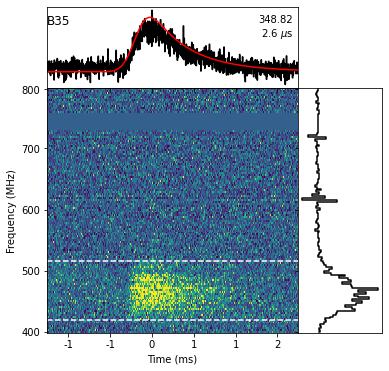

Waterfal shape (1024, 93)
Waterfall shape after scrunch (128, 93)


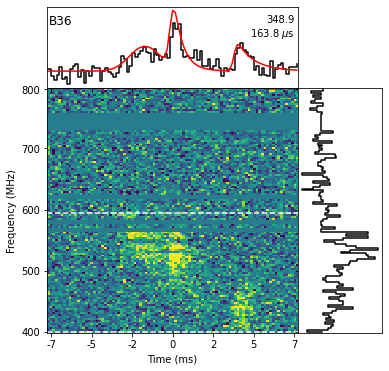

Waterfal shape (1024, 74)
Waterfall shape after scrunch (128, 74)


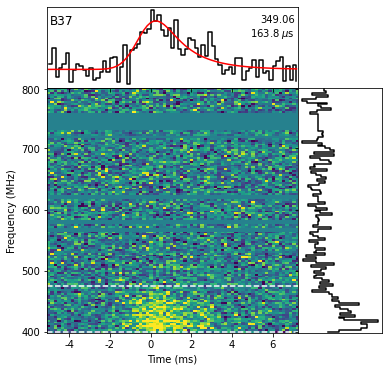

Waterfal shape (1024, 144)
Waterfall shape after scrunch (128, 144)


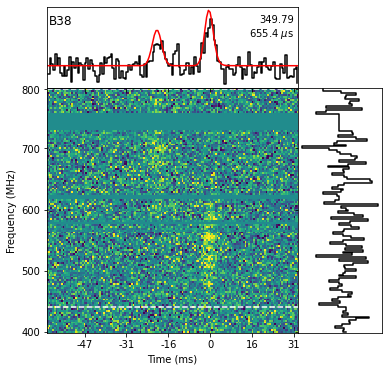

Waterfal shape (1024, 39)
Waterfall shape after scrunch (128, 39)


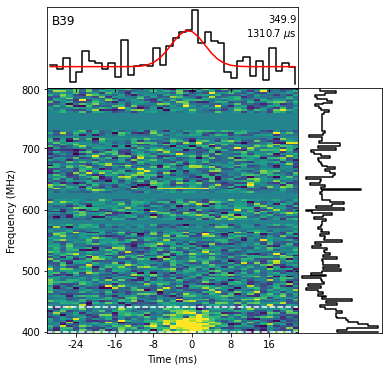

Waterfal shape (1024, 4000)
Waterfall shape after scrunch (128, 4000)


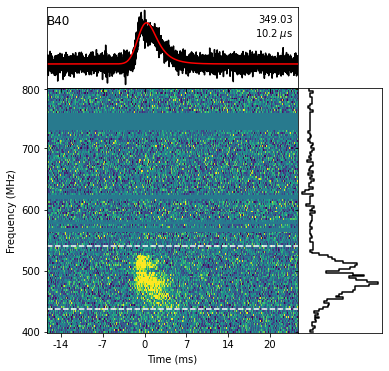

Waterfal shape (1024, 889)
Waterfall shape after scrunch (128, 889)


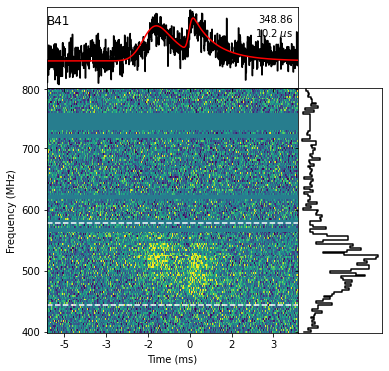

Waterfal shape (1024, 198)
Waterfall shape after scrunch (128, 198)


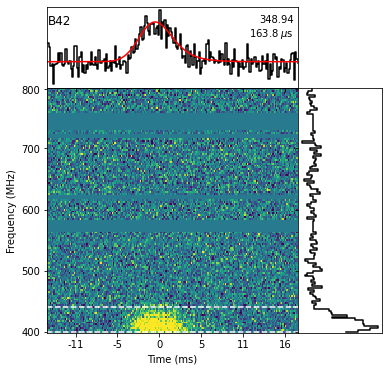

Waterfal shape (1024, 45)
Waterfall shape after scrunch (128, 45)


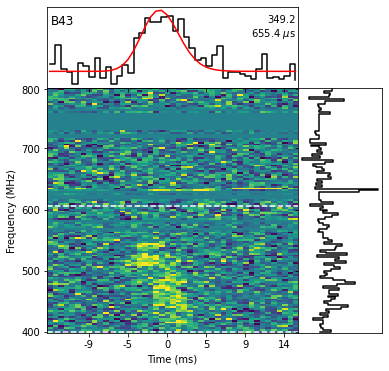

Waterfal shape (1024, 300)
Waterfall shape after scrunch (128, 300)


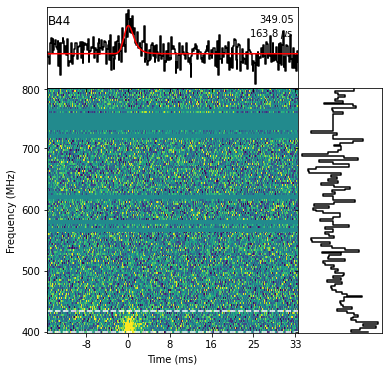

Waterfal shape (1024, 1500)
Waterfall shape after scrunch (128, 1500)


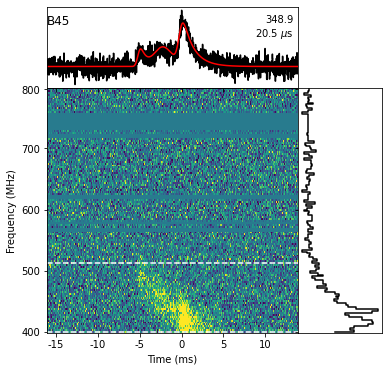

In [7]:
for j in range(0,len(npz_files),5):
    ### Loading Data ###
    wfall = npz_files[j+1]
    print("Waterfal shape", wfall.shape)
    model_wfall = npz_files[j+4]
    ds = npz_files[j+2]
    e = npz_files[j]
    dm = npz_files[j+3]
    
    save_path = '/data/user-data/ksand/baseband-analysis/playground/waterfall_bb/'
    
    f_scrunch = 8
    t_scrunch = 1
    
    f_res = (400/1024)*f_scrunch 
    t_res = 2.56*ds*t_scrunch ### Time in micro ##
    
    save_fname = save_path + 'B'+str(int(j/5)+1)+'_wfall_bb_'+'fin'+'.pdf'
    
    if ds*t_scrunch < 1024:
        wfall = scrunch_npy(wfall, f_scrunch, t_scrunch)
        model_wfall = scrunch_npy(model_wfall, f_scrunch, t_scrunch)
    else:
        print("Not Scrunching")
    
    low, high, peak = get_spec_param(model_wfall, 400, 800, model_wfall.shape[0])
    
    plot_event(wfall, model_wfall, f_res, t_res, dm, int(j/5), low, high, save_fname)
    

0
23789294 32
(1024, 320)
(1024, 320)
(320,)
(320,)
23789294 348.732
(1024,)
0.08192
[ 0.  5. 10. 15. 20. 25.]
[  0.  61. 122. 183. 244. 305.]


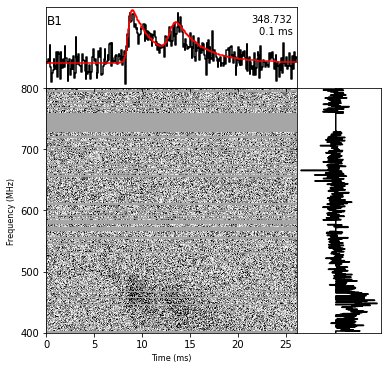

In [6]:
for j in range(0,5,5):
    print(j)
    print(npz_files[j],npz_files[j+2])
    wfall = npz_files[j+1]
    print(wfall.shape)
    model_wfall = npz_files[j+4]
    print(model_wfall.shape)
    ts = np.sum(wfall, axis=0)
    print(ts.shape)
    model_ts = np.sum(model_wfall, axis=0)
    print(model_ts.shape)
    spec = np.sum(wfall, axis=1)
    ds = npz_files[j+2]
    e = npz_files[j]
    dm = npz_files[j+3]
    print(e, dm)


    #### Plotting #####
    outer_grid = gridspec.GridSpec(1, 1, wspace=0, hspace=0.25)
    for i, outer in enumerate(outer_grid):
        outer = outer
    plt.figure(figsize=(6,6))
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer,
                                          width_ratios=[3, 1],
                                          height_ratios=[1, 3],
                                          hspace=0.0, wspace=0.0)

    data_im = plt.subplot(gs[2])
    data_ts = plt.subplot(gs[0], sharex=data_im)
    data_spec = plt.subplot(gs[3], sharey=data_im)

    plot_time = np.arange(0,len(ts),1)
    plot_freq = np.linspace(400, 800, 1024)
    print(plot_freq.shape)

    vmin = np.nanpercentile(wfall, 1)
    vmax = np.nanpercentile(wfall, 99)
    
    wfall[np.isnan(wfall)] = np.nanmedian(wfall)

#     vmin = np.std(wfall)-2
#     vmax = np.std(wfall)+2


    data_im.imshow(wfall, aspect="auto", origin='lower',interpolation="nearest", vmin=vmin, vmax=vmax, cmap='Greys')#'viridis')

    # plot time-series
    data_ts.plot(plot_time, ts, color="k", drawstyle="steps-post")
                 #,drawstyle="steps-post")

    #data_ts.plot(plot_time, np.append(ts, ts[-1]), color=eventid_color,
    #             drawstyle="steps-post")

    # plot spectrum
    data_spec.plot(spec, np.arange(0, len(spec)), color="k", drawstyle="steps-post")

    data_ts.plot(plot_time, model_ts,color="r", drawstyle="steps-post")

    plt.setp(data_ts.get_xticklabels(), visible=False)
    data_ts.set_yticklabels([], visible=True)
    data_ts.set_yticks([])
    #data_ts.set_xlim(extent[0], extent[1])
    plt.setp(data_spec.get_yticklabels(), visible=False)
    data_spec.set_xticklabels([], visible=True)
    data_spec.set_xticks([])

    t_res = ds * 2.56e-3
    print(t_res)

    y_ticks = np.linspace(0,1024,5)
    x = np.arange(0,len(ts)*t_res,5)
    print(x)
    x_ticks = np.zeros(len(x))
    for i in range(len(x)):
        x_ticks[i] = int(x[i]/t_res)
    print(x_ticks)
    #x_ticks = np.linspace(0,len(ts),10)
    xticklabels = []
    for i in range(len(x_ticks)):
        xticklabels.append(math.ceil(round(x_ticks[i]*t_res,2)))
    yticklabels = [400, 500, 600, 700, 800]
    data_im.set_yticks(y_ticks)
    data_im.set_yticklabels(yticklabels)
    data_im.set_xticks(x_ticks)
    data_im.set_xticklabels(xticklabels)
    data_im.set_ylabel("Frequency (MHz)", fontsize=8)
    data_im.set_xlabel("Time (ms)", fontsize=8)

    xlim = data_ts.get_xlim()
    ylim = data_ts.get_ylim()
    ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
    xpos = (xlim[1] - xlim[0]) * 0.98 + 0
    data_ts.text(xpos, ypos, "{}\n{:.1f} ms".format(dm, t_res), ha="right",
                 va="top", fontsize=10)
    data_ts.text(0.2,ypos,"B{}".format(int(j/5)+1), ha="left", va="top", fontsize=12)
#     oname = str(e)+"_wfall_fin.jpeg"
#     plt.savefig(oname, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
import gc
gc.collect()

40047